In [1]:
# Standard imports
import sys
import time
import logging
from pathlib import Path
import json

# Standard scientific imports
import numpy as np
from numpy.random import default_rng

# Plotting imports
import matplotlib.pyplot as plt
import cmasher as cmr

# Astronomy imports
import astropy.units as u
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from specutils import Spectrum1D

In [2]:
# Matplotlib style
try:
    plt.style.use('paper')
    plt.style.use('kraken')
except:
    pass

In [3]:
# Astropalmerio specific imports
from astropalmerio.spectra.conversions import ergscm2AA
from astropalmerio.spectra.visualization import plot_spectrum, set_standard_spectral_labels
from astropalmerio.spectra.utils import gaussian_fct
from astropalmerio.spectra.emission_lines import EmissionLine

In [4]:
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [5]:
# if you want more details about the logs
# logging.getLogger('astropalmerio.spectra').setLevel(logging.DEBUG)

# Measuring emission lines from spectra
In this example, we will see how to leverage the capabilities of `specutils` and `astropy` to fit a simple Gaussian model to an H$\alpha$ emission line in a synthetic spectrum

### Create synthetic spectrum

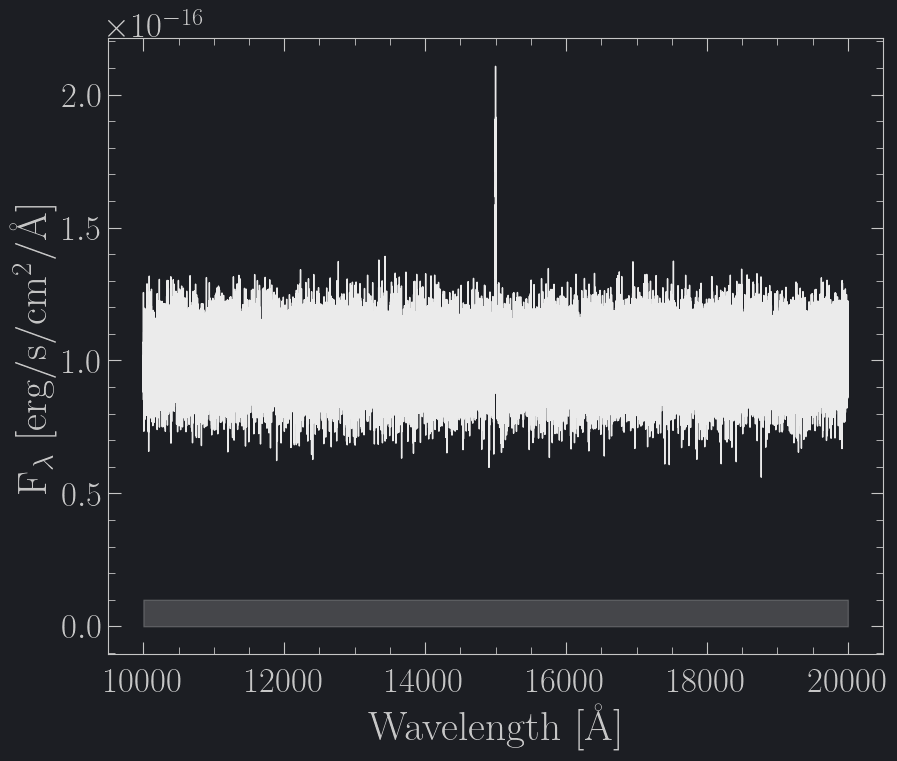

In [6]:
wave = np.arange(10000, 20000, 0.2) * u.AA
flux = (default_rng().standard_normal(len(wave)) + 10) * 1e-17 * ergscm2AA
error = 1e-17 * np.ones(len(flux)) * ergscm2AA
flux = flux + gaussian_fct(x=wave, mean=15000.0*u.AA, stddev=5.0*u.AA, amplitude=8e-17*ergscm2AA)
plot_spectrum(wave, flux, error, color='C12')
set_standard_spectral_labels()

## Create the EmissionLine object that will be used
We will provide the bounds to extract a region of the spectrum to work with.
Alternatively, we could provide a guess of the redshift of the source so that some automatic bounds can be used for the extraction.

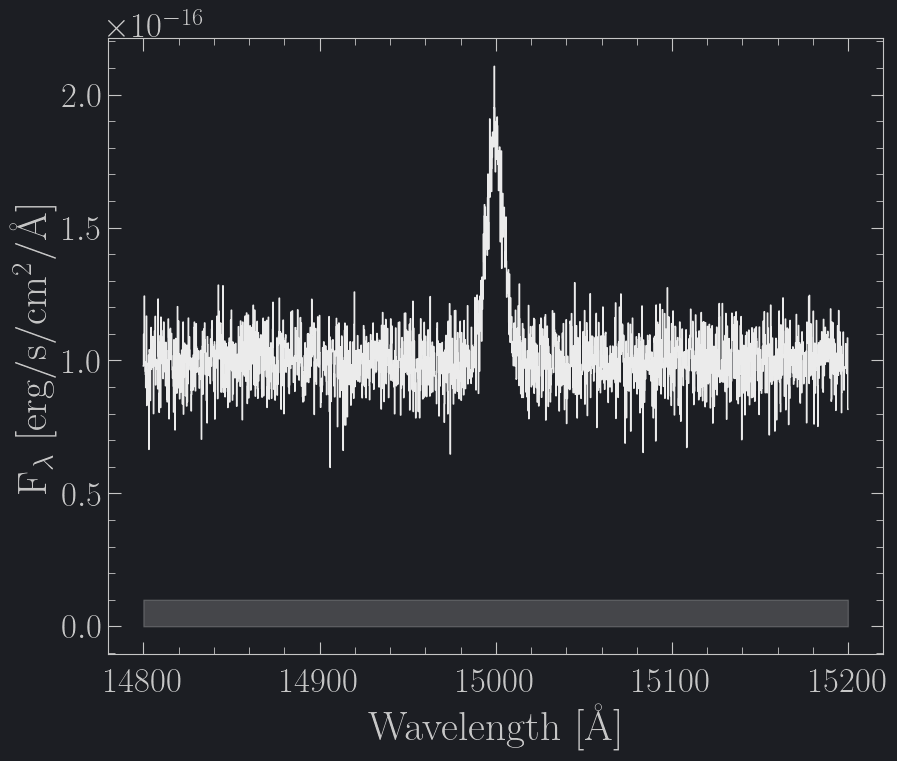

In [7]:
Ha = EmissionLine('H_alpha')
# If using a guess redshift to extract bounds
# Ha = EmissionLine('H_alpha', z_guess=1.29)

Ha.extract_line_region(
    spectrum=Spectrum1D(
        spectral_axis=wave,
        flux=flux,
        uncertainty=StdDevUncertainty(error)
    ),
    bounds=(14800*u.AA, 15200*u.AA)
)
Ha.show_spectrum(color='C12')
set_standard_spectral_labels()

### Fit the continuum

2023-03-08 15:34:29,788 WARNING [astropy] Model is linear in parameters; consider using linear fitting methods.


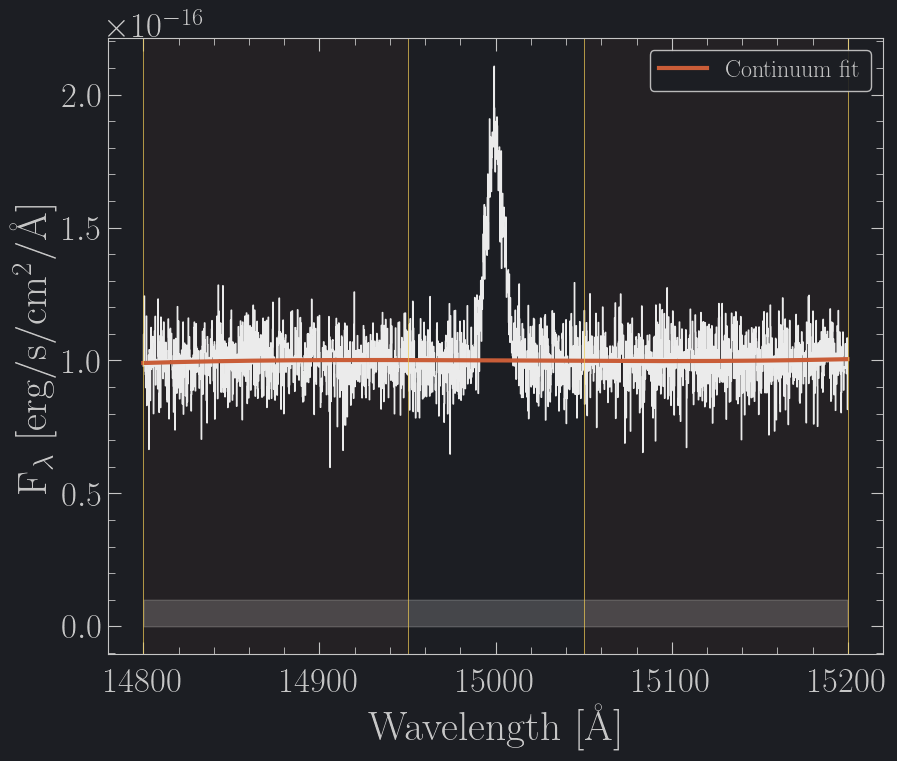

In [8]:
Ha.fit_continuum(
    regions=[
        (14800*u.AA,14950*u.AA,),
        (15050*u.AA,15200*u.AA,),
    ]
)
Ha.show_continuum(show_spec_kwargs={'color':'C12'})
plt.gca().legend()
set_standard_spectral_labels()

### Fit the line

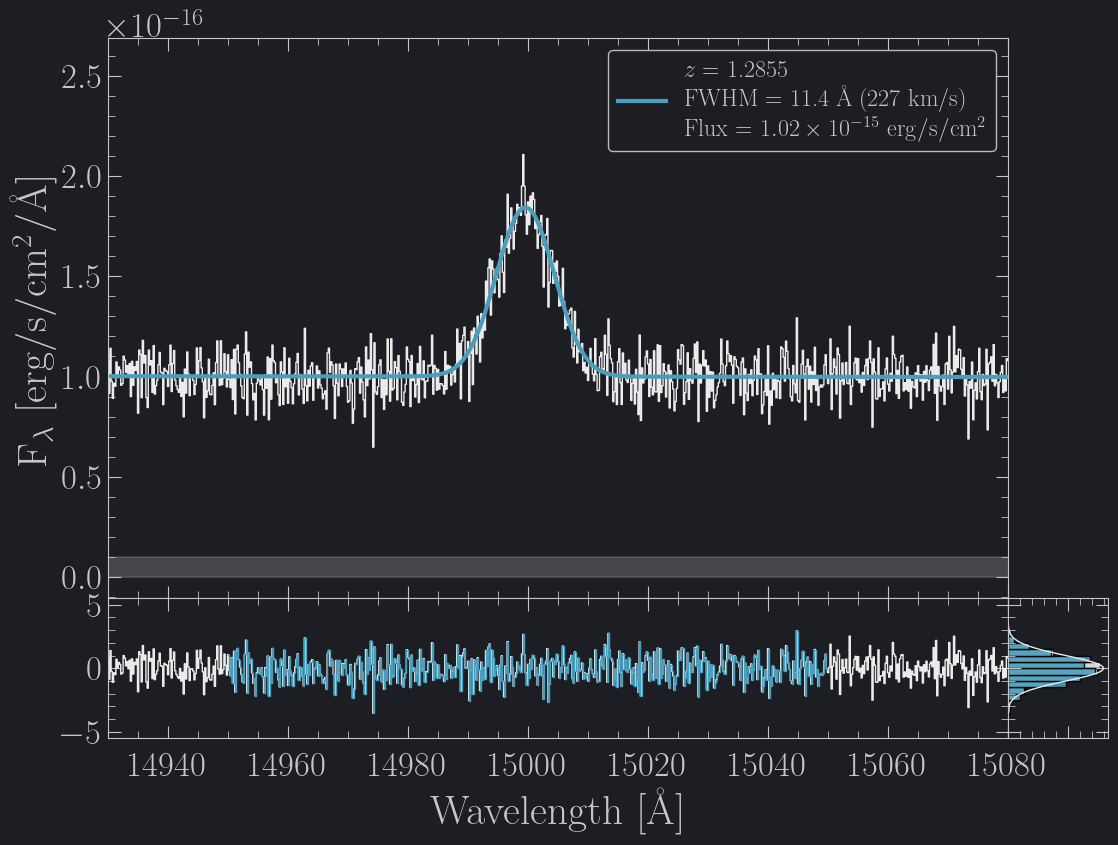

In [14]:
Ha.fit_single_gaussian(
    bounds=(14950*u.AA,15050*u.AA,)
)
Ha.show_fit(
    spec_plot_kw={'color':'C12'},
    resid_plot_kw={'show_legend':False}
)
plt.gcf().axes[0].legend()
set_standard_spectral_labels(ax_x=plt.gcf().axes[1], ax_y=plt.gcf().axes[0])
plt.gcf().axes[0].set_xlim(14930, 15080)
plt.show()

You can check the results of the fit like this:

In [10]:
Ha.fit['results']

{'amplitude': <Quantity 8.42794081e-17 ergscm2AA>,
 'mean': <Quantity 14999.5511463 Angstrom>,
 'stddev': <Quantity 4.82619154 Angstrom>}